# Analysing Calgary Campinas Dataset

In [1]:
import seaborn_image as isns
from uda.calgary_campinas_dataset import CalgaryCampinasDataset
from pathlib import Path

data_dir = Path("/home/iailab36/iser/uda-data")
output_dir = Path("/home/iailab36/iser/uda-data/output")
output_dir.mkdir(exist_ok=True, parents=True)

Load the Calgary Campinas dataset.

In [2]:
train_dataset = CalgaryCampinasDataset(data_dir, vendor="GE_3", fold=1, train=True, rotate=True, flatten=True)
test_dataset = CalgaryCampinasDataset(data_dir, vendor="GE_3", fold=1, train=False, rotate=True, flatten=True)

print(train_dataset.data.shape)
print(train_dataset.label.shape)
print(train_dataset.voxel_dim.shape)

Loading files: 100%|██████████| 20/20 [00:08<00:00,  2.37it/s]


torch.Size([8000, 1, 256, 256])
torch.Size([8000, 1, 256, 256])
torch.Size([8000, 1, 3])


Visualize some of the CT images.

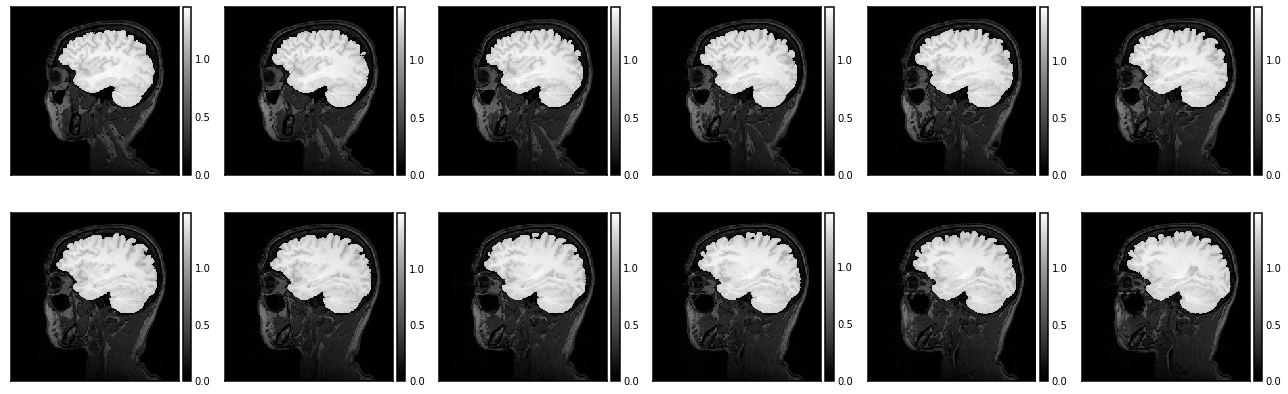

In [3]:
COLS = 6
N = 64
M = N + COLS*2

g = isns.ImageGrid(list((train_dataset.data + train_dataset.label)[N:M].squeeze()), col_wrap=COLS, cmap='gray')

## Training U-Net model

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn.functional as F
from uda import UNetConfig, UNet
from tqdm import tqdm

sns.set_theme(style='darkgrid')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "cpu"
print(f"Using device: {device}")

Using device: cuda:0


In [5]:
# Create dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)

In [6]:
# We use one encoder block less than the original U-Net, since our input is of shape (256, 256)
config = UNetConfig(
    n_classes=1,
    encoder_blocks=(
        (1, 64, 64),
        (64, 128, 128),
        (128, 256, 256),
        (256, 512, 512),
    ),
    decoder_blocks=(
        (512, 256, 256),
        (256, 128, 128),
        (128, 64, 64),
    ),
)

In [7]:
# from torchsummaryX import summary
# model = UNet(config)
# summary(model, x=torch.randn(1, 1, 512, 512))

Dice score is a common measure of the quality of segmentation. It's defined as:
$$
DSC = 2 \cdot \frac{\vert Y_{\text{true}} \cap Y_{\text{pred}} \vert}{Y_{\vert\text{true}}\vert + \vert Y_{\text{pred}} \vert}
$$

In [8]:
def dice_score(pred: torch.Tensor, target: torch.Tensor) -> float:
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    return 2 * intersection / (pred.sum() + target.sum())

Train the model:

In [9]:
model = UNet(config).to(device)
optim = torch.optim.Adam(model.parameters(), lr=1e-4)

TEST_INTERVAL = 100
MAX_STEPS = 400

train_losses, test_losses = [], []
train_dscs, test_dscs = [], []

i = 0
dsc_test = 0
with tqdm(total=MAX_STEPS, desc="Training") as pbar:
    while i < MAX_STEPS:
        for x, y_true, _ in train_loader:
            i += 1
            if i > MAX_STEPS:
                break

            x = x.to(device)
            y_true = y_true.to(device)

            optim.zero_grad()
            y_pred = model(x).sigmoid()
            loss = F.binary_cross_entropy(y_pred, y_true)

            loss.backward()
            optim.step()

            train_losses.append(loss.item())
            train_dscs.append(dice_score(y_true.cpu(), y_pred.detach().cpu()).item())

            del loss, y_pred, x, y_true

            if i % TEST_INTERVAL == 0:
                r_loss, r_dsc = 0, 0
                with torch.no_grad():
                    for x, y_true, _ in tqdm(test_loader, desc="Testing", leave=False):
                        x = x.to(device)
                        y_true = y_true.to(device)

                        y_pred = model(x).sigmoid()
                        r_loss += F.binary_cross_entropy(y_pred, y_true).item()
                        r_dsc += dice_score(y_true.cpu(), y_pred.cpu()).item()
                
                del y_pred, x, y_true
                
                test_losses.append(r_loss / len(test_loader))
                test_dscs.append(r_loss / len(test_loader))

            pbar.set_postfix({
                "loss": sum(train_losses[-10:]) / 10,
                "dsc_train": sum(train_dscs[-10:]) / 10,
                "dsc_test": test_dscs[-1] if test_dscs != [] else 0
            })
            pbar.update()

model.cpu();

Training: 100%|██████████| 400/400 [03:19<00:00,  2.01it/s, loss=0.0369, dsc_train=0.886, dsc_test=0.0635]


Visualize losses and dice score:

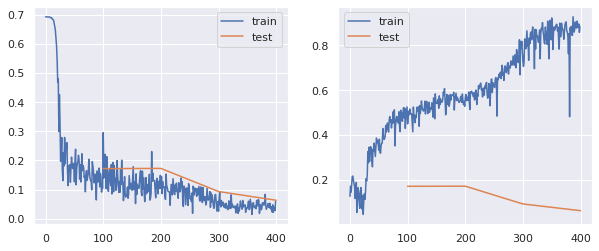

In [10]:
_, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.lineplot(x=range(len(train_losses)), y=train_losses, label="train", ax=ax[0])
sns.lineplot(x=range(TEST_INTERVAL, len(train_losses)+1, TEST_INTERVAL), y=test_losses, label="test", ax=ax[0])

sns.lineplot(x=range(len(train_dscs)), y=train_dscs, label="train", ax=ax[1])
sns.lineplot(x=range(TEST_INTERVAL, len(train_dscs)+1, TEST_INTERVAL), y=test_dscs, label="test", ax=ax[1])

plt.legend()
plt.show()

Safe the model.

In [13]:
config.save(output_dir / "unet_config.json")
model.save(output_dir / "unet_model.pt")

## Analysing model outputs
! Restart notebook to free gpu memory

In [14]:
import torch
from uda import UNetConfig, UNet

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "cpu"
print(f"Using device: {device}")

# load pretrained model
config = UNetConfig.from_file(output_dir / "unet_config.json")
model = UNet.from_pretrained(output_dir / "unet_model.pt", config)

Using device: cuda:0


Gather model outputs:

In [15]:
model = model.to(device)
dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)

with torch.no_grad():
    data, label, pred = [*zip(*[(data, label, model(data.to(device)).sigmoid().cpu()) for data, label, _ in dataloader])]

data = torch.cat(data)
label = torch.cat(label)
pred = torch.cat(pred)

Predictions vs. ground truth:

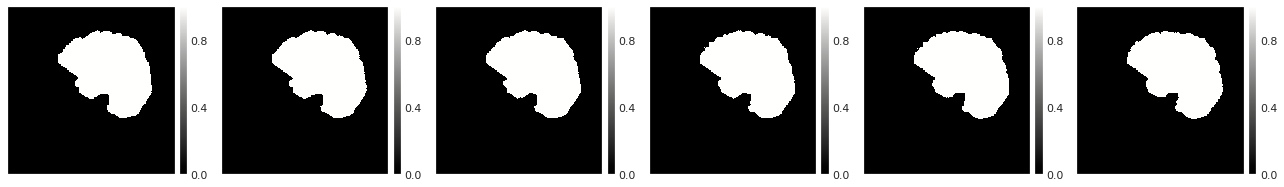

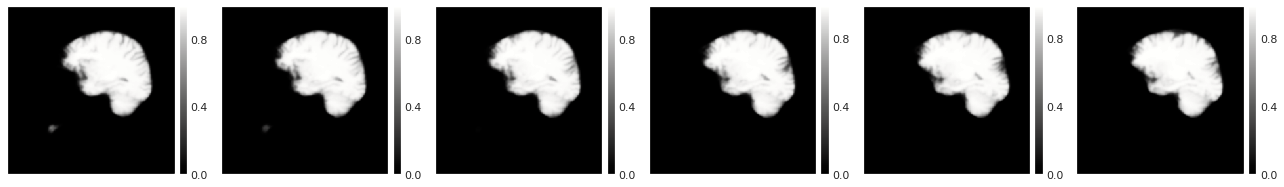

In [16]:
COLS = 6
N = 64
M = N + COLS

g = isns.ImageGrid(list((label)[N:M].squeeze()), col_wrap=COLS, cmap='gray')
g = isns.ImageGrid(list((pred)[N:M].squeeze()), col_wrap=COLS, cmap='gray')

### Safe predictions and ground truth as tif files

In [17]:
from apeer_ometiff_library import io
import numpy as np

In [18]:
# shape convention (T, Z, C, X, Y)
label = label[:200].unsqueeze(0).numpy().astype(np.uint8)
pred = pred[:200].unsqueeze(0).numpy().astype(np.uint8)

label.shape

(1, 200, 1, 256, 256)

In [19]:
io.write_ometiff(output_dir / "label.tif", label)
io.write_ometiff(output_dir / "pred.tif", pred)